[View in Colaboratory](https://colab.research.google.com/github/fahmee/loan_defaulter_prediction/blob/master/loa_def_predic.ipynb)

In [9]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

gpg: keybox '/tmp/tmp654qsmj4/pubring.gpg' created
gpg: /tmp/tmp654qsmj4/trustdb.gpg: trustdb created
gpg: key AD5F235DF639B041: public key "Launchpad PPA for Alessandro Strada" imported
gpg: Total number processed: 1
gpg:               imported: 1
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
!mkdir -p my_drive
!google-drive-ocamlfuse my_drive

In [11]:
ls

datalab/  my_drive/


In [12]:
ls my_drive

character_recognition/
Classroom/
Colab Notebooks/
CSD254-Python Programming syllabus.docx
ERP/
Getting started
ITVS - Copy.rar
Model exam timetable even sem 2017-18.doc
Mov_Rev_Trained_Model/
mp notes/
MSE/
OS.rar
PHP- UNIT IV.ppt
pred_loan_def/
screenshot/
softmax (d10c538b).py
softmax.py
text for design project/
train problem.txt
Unit-1_03_OperatorTypes&Precedence.pptx
Unit-3_02_Time&CalendarTupleFunctions.pptx
Untitled spreadsheet.ods
verbal ability.txt
VERBAL REASONING.txt


In [13]:
!ls ~/my_drive/pred_loan_def/

data  loa_def_predic.ipynb


In [14]:
!ls ~/my_drive/pred_loan_def/data/

cleaned_loans_2007.csv	 filtered_loans_2007.csv.ods  lending_club_loans.csv
filtered_loans_2007.csv  lcdatadictionary.csv


In [15]:
import pandas as pd
import numpy as np
pd.set_option('max_columns', 120)
pd.set_option('max_colwidth', 5000)


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,8)
# skip row 1 so pandas can parse the data properly.
loans_2007 = pd.read_csv('my_drive/pred_loan_def/data/lending_club_loans.csv',low_memory=False) 
half_count = len(loans_2007) / 2
loans_2007 = loans_2007.dropna(thresh=half_count,axis=1) # Drop any column with more than 50% missing values
loans_2007 = loans_2007.drop(['url','desc'],axis=1) 
loans_2007.head(3)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens
0,1077501,1296599.0,5000.0,5000.0,4975.0,36 months,0.1065,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-2011,Fully Paid,False,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-1985,735.0,739.0,1.0,3.0,0.0,13648.0,0.837,9.0,False,0.0,0.0,5863.155187,5833.84,5000.00,863.16,0.0,0.00,0.00,Jan-2015,171.62,Sep-2016,744.0,740.0,False,True,INDIVIDUAL,False,False,0.0,0.0,False
1,1077430,1314167.0,2500.0,2500.0,2500.0,60 months,0.1527,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-2011,Charged Off,False,car,bike,309xx,GA,1.00,0.0,Apr-1999,740.0,744.0,5.0,3.0,0.0,1687.0,0.094,4.0,False,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.0,117.08,1.11,Apr-2013,119.66,Sep-2016,499.0,0.0,False,True,INDIVIDUAL,False,False,0.0,0.0,False
2,1077175,1313524.0,2400.0,2400.0,2400.0,36 months,0.1596,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-2011,Fully Paid,False,small_business,real estate business,606xx,IL,8.72,0.0,Nov-2001,735.0,739.0,2.0,2.0,0.0,2956.0,0.985,10.0,False,0.0,0.0,3005.666844,3005.67,2400.00,605.67,0.0,0.00,0.00,Jun-2014,649.91,Sep-2016,719.0,715.0,False,True,INDIVIDUAL,False,False,0.0,0.0,False


In [16]:
loans_2007.shape

(42538, 56)

In [17]:
data_dictionary = pd.read_csv('my_drive/pred_loan_def/data/lcdatadictionary.csv') # Loading in the data dictionary
print(data_dictionary.shape[0])
print(data_dictionary.columns.tolist())

116
['loanstatnew', 'description']


In [18]:
data_dictionary.head()

,loanstatnew,description
0,acc_now_delinq,The number of accounts on which the borrower is now delinquent.
1,acc_open_past_24mths,Number of trades opened in past 24 months.
2,addr_state,The state provided by the borrower in the loan application
3,all_util,Balance to credit limit on all trades
4,annual_inc,The self-reported annual income provided by the borrower during registration.


In [0]:
data_dictionary.rename(columns={'loanstatnew': 'name',
                                                 'description1': 'description'},inplace=True)


In [20]:
data_dictionary.head()

,name,description
0,acc_now_delinq,The number of accounts on which the borrower is now delinquent.
1,acc_open_past_24mths,Number of trades opened in past 24 months.
2,addr_state,The state provided by the borrower in the loan application
3,all_util,Balance to credit limit on all trades
4,annual_inc,The self-reported annual income provided by the borrower during registration.


In [21]:
print(loans_2007.dtypes)


id                             object
member_id                     float64
loan_amnt                     float64
funded_amnt                   float64
funded_amnt_inv               float64
term                           object
int_rate                      float64
installment                   float64
grade                          object
sub_grade                      object
emp_title                      object
emp_length                     object
home_ownership                 object
annual_inc                    float64
verification_status            object
issue_d                        object
loan_status                    object
pymnt_plan                     object
purpose                        object
title                          object
zip_code                       object
addr_state                     object
dti                           float64
delinq_2yrs                   float64
earliest_cr_line               object
fico_range_low                float64
fico_range_h

In [0]:
loans_2007_dtypes = pd.DataFrame(loans_2007.dtypes,columns=['dtypes'])
loans_2007_dtypes = loans_2007_dtypes.reset_index()
loans_2007_dtypes['name'] = loans_2007_dtypes['index']

loans_2007_dtypes = loans_2007_dtypes[['name','dtypes']]

loans_2007_dtypes['first value'] = loans_2007.loc[0].values
preview = loans_2007_dtypes.merge(data_dictionary, on='name',how='left')



In [23]:
preview.head()

,name,dtypes,first value,description
0,id,object,1077501,A unique LC assigned ID for the loan listing.
1,member_id,float64,1.2966e+06,A unique LC assigned Id for the borrower member.
2,loan_amnt,float64,5000,"The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value."
3,funded_amnt,float64,5000,The total amount committed to that loan at that point in time.
4,funded_amnt_inv,float64,4975,The total amount committed by investors for that loan at that point in time.


In [24]:
preview[:19]

,name,dtypes,first value,description
0,id,object,1077501,A unique LC assigned ID for the loan listing.
1,member_id,float64,1.2966e+06,A unique LC assigned Id for the borrower member.
2,loan_amnt,float64,5000,"The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value."
3,funded_amnt,float64,5000,The total amount committed to that loan at that point in time.
4,funded_amnt_inv,float64,4975,The total amount committed by investors for that loan at that point in time.
5,term,object,36 months,The number of payments on the loan. Values are in months and can be either 36 or 60.
6,int_rate,float64,0.1065,Interest Rate on the loan
7,installment,float64,162.87,The monthly payment owed by the borrower if the loan originates.
8,grade,object,B,LC assigned loan grade
9,sub_grade,object,B2,LC assigned loan subgrade


In [0]:
drop_list = ['id','member_id','funded_amnt','funded_amnt_inv',
             'int_rate','sub_grade','emp_title','issue_d']
loans_2007 = loans_2007.drop(drop_list,axis=1)

In [26]:
preview[19:38]

,name,dtypes,first value,description
19,title,object,Computer,The loan title provided by the borrower
20,zip_code,object,860xx,The first 3 numbers of the zip code provided by the borrower in the loan application.
21,addr_state,object,AZ,The state provided by the borrower in the loan application
22,dti,float64,27.65,"A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income."
23,delinq_2yrs,float64,0,The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years
24,earliest_cr_line,object,Jan-1985,The month the borrower's earliest reported credit line was opened
25,fico_range_low,float64,735,The lower boundary range the borrower’s FICO at loan origination belongs to.
26,fico_range_high,float64,739,The upper boundary range the borrower’s FICO at loan origination belongs to.
27,inq_last_6mths,float64,1,The number of inquiries in past 6 months (excluding auto and mortgage inquiries)
28,open_acc,float64,3,The number of open credit lines in the borrower's credit file.


In [0]:
drop_cols = [ 'zip_code','out_prncp','out_prncp_inv',
             'total_pymnt','total_pymnt_inv']
loans_2007 = loans_2007.drop(drop_cols, axis=1)

In [28]:
preview[38:]

,name,dtypes,first value,description
38,total_rec_prncp,float64,5000,Principal received to date
39,total_rec_int,float64,863.16,Interest received to date
40,total_rec_late_fee,float64,0,Late fees received to date
41,recoveries,float64,0,post charge off gross recovery
42,collection_recovery_fee,float64,0,post charge off collection fee
43,last_pymnt_d,object,Jan-2015,Last month payment was received
44,last_pymnt_amnt,float64,171.62,Last total payment amount received
45,last_credit_pull_d,object,Sep-2016,The most recent month LC pulled credit for this loan
46,last_fico_range_high,float64,744,The upper boundary range the borrower’s last FICO pulled belongs to.
47,last_fico_range_low,float64,740,The lower boundary range the borrower’s last FICO pulled belongs to.


In [0]:
drop_cols = ['total_rec_prncp','total_rec_int', 'total_rec_late_fee',
             'recoveries', 'collection_recovery_fee', 'last_pymnt_d',
             'last_pymnt_amnt']

loans_2007 = loans_2007.drop(drop_cols, axis=1)

In [30]:
loans_2007.shape

(42538, 36)

42538
42535


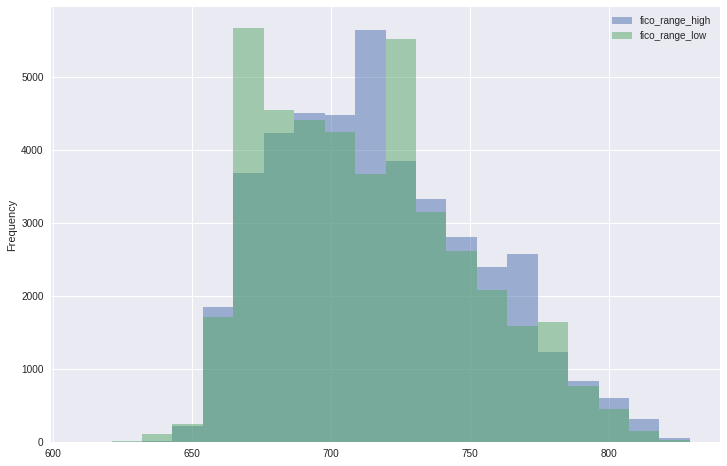

In [31]:
fico_columns = ['fico_range_high','fico_range_low']

print(loans_2007.shape[0])
loans_2007.dropna(subset=fico_columns,inplace=True)
print(loans_2007.shape[0])

loans_2007[fico_columns].plot.hist(alpha=0.5,bins=20);

In [0]:
loans_2007['fico_average'] = (loans_2007['fico_range_high'] + loans_2007['fico_range_low']) / 2

In [33]:
cols = ['fico_range_low','fico_range_high','fico_average']
loans_2007[cols].head()

,fico_range_low,fico_range_high,fico_average
0,735.0,739.0,737.0
1,740.0,744.0,742.0
2,735.0,739.0,737.0
3,690.0,694.0,692.0
4,695.0,699.0,697.0


In [34]:
drop_cols = ['fico_range_low','fico_range_high','last_fico_range_low',
             'last_fico_range_high']
loans_2007 = loans_2007.drop(drop_cols, axis=1)
loans_2007.shape

(42535, 33)

In [35]:
loans_2007.head()

,loan_amnt,term,installment,grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,pymnt_plan,purpose,title,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens,fico_average
0,5000.0,36 months,162.87,B,10+ years,RENT,24000.0,Verified,Fully Paid,False,credit_card,Computer,AZ,27.65,0.0,Jan-1985,1.0,3.0,0.0,13648.0,0.837,9.0,False,Sep-2016,False,True,INDIVIDUAL,False,False,0.0,0.0,False,737.0
1,2500.0,60 months,59.83,C,< 1 year,RENT,30000.0,Source Verified,Charged Off,False,car,bike,GA,1.00,0.0,Apr-1999,5.0,3.0,0.0,1687.0,0.094,4.0,False,Sep-2016,False,True,INDIVIDUAL,False,False,0.0,0.0,False,742.0
2,2400.0,36 months,84.33,C,10+ years,RENT,12252.0,Not Verified,Fully Paid,False,small_business,real estate business,IL,8.72,0.0,Nov-2001,2.0,2.0,0.0,2956.0,0.985,10.0,False,Sep-2016,False,True,INDIVIDUAL,False,False,0.0,0.0,False,737.0
3,10000.0,36 months,339.31,C,10+ years,RENT,49200.0,Source Verified,Fully Paid,False,other,personel,CA,20.00,0.0,Feb-1996,1.0,10.0,0.0,5598.0,0.210,37.0,False,Apr-2016,False,True,INDIVIDUAL,False,False,0.0,0.0,False,692.0
4,3000.0,60 months,67.79,B,1 year,RENT,80000.0,Source Verified,Current,False,other,Personal,OR,17.94,0.0,Jan-1996,0.0,15.0,0.0,27783.0,0.539,38.0,False,Sep-2016,False,True,INDIVIDUAL,False,False,0.0,0.0,False,697.0


In [36]:
loans_2007["loan_status"].value_counts()

Fully Paid                                             33586
Charged Off                                             5653
Does not meet the credit policy. Status:Fully Paid      1988
Does not meet the credit policy. Status:Charged Off      761
Current                                                  513
In Grace Period                                           16
Late (31-120 days)                                        12
Late (16-30 days)                                          5
Default                                                    1
Name: loan_status, dtype: int64

In [37]:
meaning = [
    "Loan has been fully paid off.",
    "Loan for which there is no longer a reasonable expectation of further payments.",
    "While the loan was paid off, the loan application today would no longer meet the credit policy and wouldn't be approved on to the marketplace.",
    "While the loan was charged off, the loan application today would no longer meet the credit policy and wouldn't be approved on to the marketplace.",
    "Loan is up to date on current payments.",
    "The loan is past due but still in the grace period of 15 days.",
    "Loan hasn't been paid in 31 to 120 days (late on the current payment).",
    "Loan hasn't been paid in 16 to 30 days (late on the current payment).",
    "Loan is defaulted on and no payment has been made for more than 121 days."]

status, count = loans_2007["loan_status"].value_counts().index, loans_2007["loan_status"].value_counts().values

loan_statuses_explanation = pd.DataFrame({'Loan Status': status,'Count': count,'Meaning': meaning})[['Loan Status','Count','Meaning']]
loan_statuses_explanation

,Loan Status,Count,Meaning
0,Fully Paid,33586,Loan has been fully paid off.
1,Charged Off,5653,Loan for which there is no longer a reasonable expectation of further payments.
2,Does not meet the credit policy. Status:Fully Paid,1988,"While the loan was paid off, the loan application today would no longer meet the credit policy and wouldn't be approved on to the marketplace."
3,Does not meet the credit policy. Status:Charged Off,761,"While the loan was charged off, the loan application today would no longer meet the credit policy and wouldn't be approved on to the marketplace."
4,Current,513,Loan is up to date on current payments.
5,In Grace Period,16,The loan is past due but still in the grace period of 15 days.
6,Late (31-120 days),12,Loan hasn't been paid in 31 to 120 days (late on the current payment).
7,Late (16-30 days),5,Loan hasn't been paid in 16 to 30 days (late on the current payment).
8,Default,1,Loan is defaulted on and no payment has been made for more than 121 days.


In [38]:
loans_2007 = loans_2007[(loans_2007["loan_status"] == "Fully Paid") |
                            (loans_2007["loan_status"] == "Charged Off")]
loans_2007.head(10)


,loan_amnt,term,installment,grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,pymnt_plan,purpose,title,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens,fico_average
0,5000.0,36 months,162.87,B,10+ years,RENT,24000.0,Verified,Fully Paid,False,credit_card,Computer,AZ,27.65,0.0,Jan-1985,1.0,3.0,0.0,13648.0,0.837,9.0,False,Sep-2016,False,True,INDIVIDUAL,False,False,0.0,0.0,False,737.0
1,2500.0,60 months,59.83,C,< 1 year,RENT,30000.0,Source Verified,Charged Off,False,car,bike,GA,1.00,0.0,Apr-1999,5.0,3.0,0.0,1687.0,0.094,4.0,False,Sep-2016,False,True,INDIVIDUAL,False,False,0.0,0.0,False,742.0
2,2400.0,36 months,84.33,C,10+ years,RENT,12252.0,Not Verified,Fully Paid,False,small_business,real estate business,IL,8.72,0.0,Nov-2001,2.0,2.0,0.0,2956.0,0.985,10.0,False,Sep-2016,False,True,INDIVIDUAL,False,False,0.0,0.0,False,737.0
3,10000.0,36 months,339.31,C,10+ years,RENT,49200.0,Source Verified,Fully Paid,False,other,personel,CA,20.00,0.0,Feb-1996,1.0,10.0,0.0,5598.0,0.210,37.0,False,Apr-2016,False,True,INDIVIDUAL,False,False,0.0,0.0,False,692.0
5,5000.0,36 months,156.46,A,3 years,RENT,36000.0,Source Verified,Fully Paid,False,wedding,My wedding loan I promise to pay back,AZ,11.20,0.0,Nov-2004,3.0,9.0,0.0,7963.0,0.283,12.0,False,Jan-2016,False,True,INDIVIDUAL,False,False,0.0,0.0,False,732.0
6,7000.0,60 months,170.08,C,8 years,RENT,47004.0,Not Verified,Fully Paid,False,debt_consolidation,Loan,NC,23.51,0.0,Jul-2005,1.0,7.0,0.0,17726.0,0.856,11.0,False,Sep-2016,False,True,INDIVIDUAL,False,False,0.0,0.0,False,692.0
7,3000.0,36 months,109.43,E,9 years,RENT,48000.0,Source Verified,Fully Paid,False,car,Car Downpayment,CA,5.35,0.0,Jan-2007,2.0,4.0,0.0,8221.0,0.875,4.0,False,Dec-2014,False,True,INDIVIDUAL,False,False,0.0,0.0,False,662.0
8,5600.0,60 months,152.39,F,4 years,OWN,40000.0,Source Verified,Charged Off,False,small_business,Expand Business & Buy Debt Portfolio,CA,5.55,0.0,Apr-2004,2.0,11.0,0.0,5210.0,0.326,13.0,False,Sep-2016,False,True,INDIVIDUAL,False,False,0.0,0.0,False,677.0
9,5375.0,60 months,121.45,B,< 1 year,RENT,15000.0,Verified,Charged Off,False,other,Building my credit history.,TX,18.08,0.0,Sep-2004,0.0,2.0,0.0,9279.0,0.365,3.0,False,Sep-2016,False,True,INDIVIDUAL,False,False,0.0,0.0,False,727.0
10,6500.0,60 months,153.45,C,5 years,OWN,72000.0,Not Verified,Fully Paid,False,debt_consolidation,High intrest Consolidation,AZ,16.12,0.0,Jan-1998,2.0,14.0,0.0,4032.0,0.206,23.0,False,Dec-2015,False,True,INDIVIDUAL,False,False,0.0,0.0,False,697.0


In [39]:
mapping_dictionary = {"loan_status":{ "Fully Paid": 1, "Charged Off": 0}}
loans_2007 = loans_2007.replace(mapping_dictionary)
loans_2007.head(5)

,loan_amnt,term,installment,grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,pymnt_plan,purpose,title,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens,fico_average
0,5000.0,36 months,162.87,B,10+ years,RENT,24000.0,Verified,1,False,credit_card,Computer,AZ,27.65,0.0,Jan-1985,1.0,3.0,0.0,13648.0,0.837,9.0,False,Sep-2016,False,True,INDIVIDUAL,False,False,0.0,0.0,False,737.0
1,2500.0,60 months,59.83,C,< 1 year,RENT,30000.0,Source Verified,0,False,car,bike,GA,1.00,0.0,Apr-1999,5.0,3.0,0.0,1687.0,0.094,4.0,False,Sep-2016,False,True,INDIVIDUAL,False,False,0.0,0.0,False,742.0
2,2400.0,36 months,84.33,C,10+ years,RENT,12252.0,Not Verified,1,False,small_business,real estate business,IL,8.72,0.0,Nov-2001,2.0,2.0,0.0,2956.0,0.985,10.0,False,Sep-2016,False,True,INDIVIDUAL,False,False,0.0,0.0,False,737.0
3,10000.0,36 months,339.31,C,10+ years,RENT,49200.0,Source Verified,1,False,other,personel,CA,20.00,0.0,Feb-1996,1.0,10.0,0.0,5598.0,0.210,37.0,False,Apr-2016,False,True,INDIVIDUAL,False,False,0.0,0.0,False,692.0
5,5000.0,36 months,156.46,A,3 years,RENT,36000.0,Source Verified,1,False,wedding,My wedding loan I promise to pay back,AZ,11.20,0.0,Nov-2004,3.0,9.0,0.0,7963.0,0.283,12.0,False,Jan-2016,False,True,INDIVIDUAL,False,False,0.0,0.0,False,732.0


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


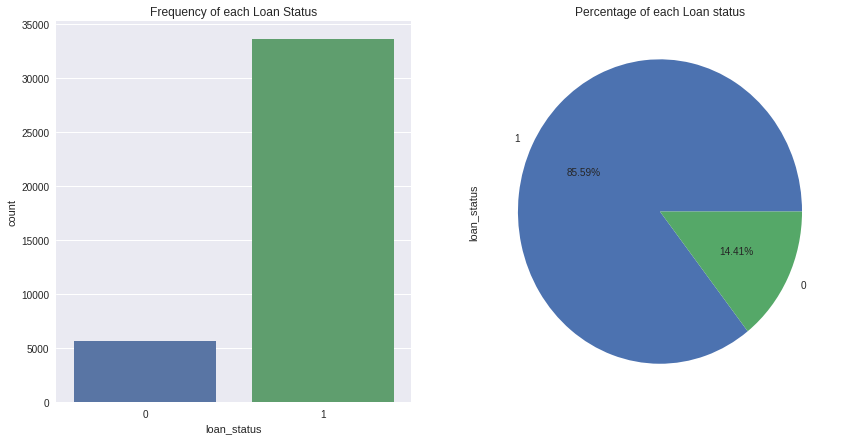

In [40]:
fig, axs = plt.subplots(1,2,figsize=(14,7))
sns.countplot(x='loan_status',data=loans_2007,ax=axs[0])
axs[0].set_title("Frequency of each Loan Status")
loans_2007.loan_status.value_counts().plot(x=None,y=None, kind='pie', ax=axs[1],autopct='%1.2f%%')
axs[1].set_title("Percentage of each Loan status")
plt.show()

In [41]:
print(loans_2007.apply(pd.Series.nunique))

loan_amnt                       876
term                              2
installment                   15241
grade                             7
emp_length                       11
home_ownership                    5
annual_inc                     5282
verification_status               3
loan_status                       2
pymnt_plan                        2
purpose                          14
title                         19512
addr_state                       50
dti                            2860
delinq_2yrs                      11
earliest_cr_line                526
inq_last_6mths                    9
open_acc                         40
pub_rec                           5
revol_bal                     21517
revol_util                     1089
total_acc                        82
initial_list_status               1
last_credit_pull_d              110
collections_12_mths_ex_med        1
policy_code                       1
application_type                  1
acc_now_delinq              

In [0]:
loans_2007 = loans_2007.loc[:,loans_2007.apply(pd.Series.nunique) != 1]

In [43]:
for col in loans_2007.columns:
    if (len(loans_2007[col].unique()) < 4):
        print(loans_2007[col].value_counts())
        print()

 36 months    29096
 60 months    10143
Name: term, dtype: int64

Not Verified       16845
Verified           12526
Source Verified     9868
Name: verification_status, dtype: int64

1    33586
0     5653
Name: loan_status, dtype: int64

False    39238
True         1
Name: pymnt_plan, dtype: int64



In [44]:
print(loans_2007.shape[1])
loans_2007 = loans_2007.drop('pymnt_plan', axis=1)
print("We've been able to reduced the features to => {}".format(loans_2007.shape[1]))

25
We've been able to reduced the features to => 24


In [0]:
loans_2007.to_csv("my_drive/pred_loan_def/data/filtered_loans_2007.csv",index=False)

In [46]:
filtered_loans = pd.read_csv('my_drive/pred_loan_def/data/filtered_loans_2007.csv')
print(filtered_loans.shape)
filtered_loans.head()

(39239, 24)


,loan_amnt,term,installment,grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,title,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,last_credit_pull_d,pub_rec_bankruptcies,fico_average
0,5000.0,36 months,162.87,B,10+ years,RENT,24000.0,Verified,1,credit_card,Computer,AZ,27.65,0.0,Jan-1985,1.0,3.0,0.0,13648.0,0.837,9.0,Sep-2016,0.0,737.0
1,2500.0,60 months,59.83,C,< 1 year,RENT,30000.0,Source Verified,0,car,bike,GA,1.00,0.0,Apr-1999,5.0,3.0,0.0,1687.0,0.094,4.0,Sep-2016,0.0,742.0
2,2400.0,36 months,84.33,C,10+ years,RENT,12252.0,Not Verified,1,small_business,real estate business,IL,8.72,0.0,Nov-2001,2.0,2.0,0.0,2956.0,0.985,10.0,Sep-2016,0.0,737.0
3,10000.0,36 months,339.31,C,10+ years,RENT,49200.0,Source Verified,1,other,personel,CA,20.00,0.0,Feb-1996,1.0,10.0,0.0,5598.0,0.210,37.0,Apr-2016,0.0,692.0
4,5000.0,36 months,156.46,A,3 years,RENT,36000.0,Source Verified,1,wedding,My wedding loan I promise to pay back,AZ,11.20,0.0,Nov-2004,3.0,9.0,0.0,7963.0,0.283,12.0,Jan-2016,0.0,732.0


In [47]:
null_counts = filtered_loans.isnull().sum()
print("Number of null values in each column:\n{}".format(null_counts))

Number of null values in each column:
loan_amnt                  0
term                       0
installment                0
grade                      0
emp_length              1057
home_ownership             0
annual_inc                 0
verification_status        0
loan_status                0
purpose                    0
title                     11
addr_state                 0
dti                        0
delinq_2yrs                0
earliest_cr_line           0
inq_last_6mths             0
open_acc                   0
pub_rec                    0
revol_bal                  0
revol_util                50
total_acc                  0
last_credit_pull_d         2
pub_rec_bankruptcies     697
fico_average               0
dtype: int64


In [0]:
filtered_loans = filtered_loans.drop("pub_rec_bankruptcies",axis=1)
filtered_loans = filtered_loans.dropna()

In [49]:
print("Data types and their frequency\n{}".format(filtered_loans.dtypes.value_counts()))

Data types and their frequency
float64    12
object     10
int64       1
dtype: int64


In [50]:
object_columns_df = filtered_loans.select_dtypes(include=['object'])
print(object_columns_df.iloc[0])

term                     36 months
grade                            B
emp_length               10+ years
home_ownership                RENT
verification_status       Verified
purpose                credit_card
title                     Computer
addr_state                      AZ
earliest_cr_line          Jan-1985
last_credit_pull_d        Sep-2016
Name: 0, dtype: object


In [51]:
cols = ['home_ownership', 'grade','verification_status', 'emp_length', 'term', 'addr_state']
for name in cols:
    print(name,':')
    print(object_columns_df[name].value_counts(),'\n')

home_ownership :
RENT        18271
MORTGAGE    16945
OWN          2808
OTHER          96
NONE            3
Name: home_ownership, dtype: int64 

grade :
B    11545
A     9675
C     7801
D     5086
E     2715
F      993
G      308
Name: grade, dtype: int64 

verification_status :
Not Verified       16391
Verified           12070
Source Verified     9662
Name: verification_status, dtype: int64 

emp_length :
10+ years    8715
< 1 year     4542
2 years      4344
3 years      4050
4 years      3385
5 years      3243
1 year       3207
6 years      2198
7 years      1738
8 years      1457
9 years      1244
Name: emp_length, dtype: int64 

term :
 36 months    28234
 60 months     9889
Name: term, dtype: int64 

addr_state :
CA    6833
NY    3657
FL    2741
TX    2639
NJ    1802
IL    1476
PA    1460
VA    1359
GA    1340
MA    1292
OH    1167
MD    1020
AZ     819
WA     796
CO     755
NC     747
CT     719
MI     684
MO     653
MN     586
NV     473
SC     461
WI     433
OR     427
AL     42

In [52]:
for name in ['purpose','title']:
    print("Unique Values in column: {}\n".format(name))
    print(filtered_loans[name].value_counts(),'\n')

Unique Values in column: purpose

debt_consolidation    17965
credit_card            4944
other                  3764
home_improvement       2852
major_purchase         2105
small_business         1749
car                    1483
wedding                 927
medical                 663
moving                  556
house                   359
vacation                349
educational             312
renewable_energy         95
Name: purpose, dtype: int64 

Unique Values in column: title

Debt Consolidation                          2102
Debt Consolidation Loan                     1635
Personal Loan                                632
Consolidation                                495
debt consolidation                           476
Credit Card Consolidation                    346
Home Improvement                             340
Debt consolidation                           321
Small Business Loan                          305
Credit Card Loan                             299
Personal              

In [0]:
drop_cols = ['last_credit_pull_d','addr_state','title','earliest_cr_line']
filtered_loans = filtered_loans.drop(drop_cols,axis=1)

In [54]:
filtered_loans.shape

(38123, 19)

In [55]:
mapping_dict = {
    "emp_length": {
        "10+ years": 10,
        "9 years": 9,
        "8 years": 8,
        "7 years": 7,
        "6 years": 6,
        "5 years": 5,
        "4 years": 4,
        "3 years": 3,
        "2 years": 2,
        "1 year": 1,
        "< 1 year": 0,
        "n/a": 0

    },
    "grade":{
        "A": 1,
        "B": 2,
        "C": 3,
        "D": 4,
        "E": 5,
        "F": 6,
        "G": 7
    }
}

filtered_loans = filtered_loans.replace(mapping_dict)
filtered_loans[['emp_length','grade']].head()

,emp_length,grade
0,10,2
1,0,3
2,10,3
3,10,3
4,3,1


In [0]:
nominal_columns = ["home_ownership", "verification_status", "purpose", "term"]
dummy_df = pd.get_dummies(filtered_loans[nominal_columns])
filtered_loans = pd.concat([filtered_loans, dummy_df], axis=1)
filtered_loans = filtered_loans.drop(nominal_columns, axis=1)

In [57]:
filtered_loans.head(10)

,loan_amnt,installment,grade,emp_length,annual_inc,loan_status,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,fico_average,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,term_ 36 months,term_ 60 months
0,5000.0,162.87,2,10,24000.0,1,27.65,0.0,1.0,3.0,0.0,13648.0,0.837,9.0,737.0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,2500.0,59.83,3,0,30000.0,0,1.00,0.0,5.0,3.0,0.0,1687.0,0.094,4.0,742.0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,2400.0,84.33,3,10,12252.0,1,8.72,0.0,2.0,2.0,0.0,2956.0,0.985,10.0,737.0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
3,10000.0,339.31,3,10,49200.0,1,20.00,0.0,1.0,10.0,0.0,5598.0,0.210,37.0,692.0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
4,5000.0,156.46,1,3,36000.0,1,11.20,0.0,3.0,9.0,0.0,7963.0,0.283,12.0,732.0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
5,7000.0,170.08,3,8,47004.0,1,23.51,0.0,1.0,7.0,0.0,17726.0,0.856,11.0,692.0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
6,3000.0,109.43,5,9,48000.0,1,5.35,0.0,2.0,4.0,0.0,8221.0,0.875,4.0,662.0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
7,5600.0,152.39,6,4,40000.0,0,5.55,0.0,2.0,11.0,0.0,5210.0,0.326,13.0,677.0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
8,5375.0,121.45,2,0,15000.0,0,18.08,0.0,0.0,2.0,0.0,9279.0,0.365,3.0,727.0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
9,6500.0,153.45,3,5,72000.0,1,16.12,0.0,2.0,14.0,0.0,4032.0,0.206,23.0,697.0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1


In [58]:
filtered_loans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38123 entries, 0 to 39238
Data columns (total 39 columns):
loan_amnt                              38123 non-null float64
installment                            38123 non-null float64
grade                                  38123 non-null int64
emp_length                             38123 non-null int64
annual_inc                             38123 non-null float64
loan_status                            38123 non-null int64
dti                                    38123 non-null float64
delinq_2yrs                            38123 non-null float64
inq_last_6mths                         38123 non-null float64
open_acc                               38123 non-null float64
pub_rec                                38123 non-null float64
revol_bal                              38123 non-null float64
revol_util                             38123 non-null float64
total_acc                              38123 non-null float64
fico_average                 

In [0]:
filtered_loans.to_csv("my_drive/pred_loan_def/data/cleaned_loans_2007.csv",index=False)

In [0]:
df = pd.read_csv('my_drive/pred_loan_def/data/cleaned_loans_2007.csv')

**KNeighbors model**

In [61]:
#### predifined model
from sklearn import model_selection, neighbors
X = np.array(df.drop(['loan_status'], 1))
y = np.array(df['loan_status'])
X_train, X_test, y_train, y_test =model_selection.train_test_split(X, y, test_size=0.2)

clf = neighbors.KNeighborsClassifier()
clf.fit(X_train, y_train)
accuracy = clf.score(X_test, y_test)
print("KNeighbors Accuracy",accuracy)

###


KNeighbors Accuracy 0.8423606557377049


**LogisticRegression** model

In [62]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)
model.score(X, y)
accuracy = model.score(X_test, y_test)
print("LogisticRegression Accuracy",accuracy)

LogisticRegression Accuracy 0.8604590163934426


**Decision Tree model**

In [65]:
from sklearn import tree
model1 = tree.DecisionTreeClassifier(criterion='entropy')
model1.fit(X_train, y_train)
model1.score(X, y)
accuracy = model1.score(X_test, y_test)
print("Decision Tree Accuracy",accuracy)

Decision Tree Accuracy 0.7651147540983606
